# Chapter 10: Networks in Space and Time
## Working With Space Data

In [1]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (7.5, 7.5),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from numpy import random as nprand
seed = hash("Network Science in Python") % 2**32
nprand.seed(seed)
random.seed(seed)
# Import NetworkX
import networkx as nx

In [2]:
# Load data file into network
from pathlib import Path
data_dir = Path('.') / 'data'
G_air = nx.Graph()
with open(data_dir / 'BTS2018' / 'carrier.csv') as f:
    # Skip header
    next(f)
    # Loop through data rows
    for row in f:
        count, v, w, year, month = row.strip().split(',')
        count = int(count)
        if count == 0 or v == w:
            continue
        try:
            G_air.edges[v, w]['count'] += count
        except KeyError:
            G_air.add_edge(v, w, count=count)

In [ ]:
# Load latitude and longitude of airports
airport_lat_long = {}
with open(data_dir / 'partow' / 'GlobalAirportDatabase.txt') as f:
    for row in f:
        columns = row.strip().split(':')
        code = columns[1]
        lat = float(columns[14])
        long = float(columns[15])
        airport_lat_long[code] = (lat, long)


In [ ]:
# Add latitude and longitude to nodes, limit nodes to continental US
for v in list(G_air.nodes()):
    try:
        lat, long = airport_lat_long[v]
        if long == 0 or long < -128.6 or lat == 0 or lat < 23.5:
            G_air.remove_node(v)
            continue
        G_air.nodes[v]['lat'] = lat
        G_air.nodes[v]['long'] = long
    except KeyError:
        G_air.remove_node(v)

In [ ]:
G_air = nx.subgraph(G_air, max(nx.connected_components(G_air), key=len))

In [ ]:
nx.draw_networkx(
    G_air, node_size=0, with_labels=False, edge_coor='#666666', alpha=0.1)

In [ ]:
# Create geographc position
import math
pos = dict()
for v in G_air.nodes:
    long = G_air.nodes[v]['long']
    lat = G_air.nodes[v]['lat']
    pos[v] = ((long + 90) * math.cos(2 * math.pi * lat / 360), lat)

In [ ]:
# Draw network geographically
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1)
max_weight = max([G_air.edges[e]['count'] for e in G_air.edges])
nx.draw_networkx_nodes(G_air, pos=pos, node_color='#7f7fff', node_size=20)
for e in G_air.edges:
    alpha = G_air.edges[e]['count'] / max_weight
    nx.draw_networkx_edges(
        G_air, pos=pos, edgelist=[e], edge_color='#7f7fff', alpha=alpha, arrows=False)
ax.set_aspect(1)

In [ ]:
def haversine(q, p):
    '''Calculate the distance between two (lat, long) points'''
    R_km = 6371
    theta1 = q[1] * math.pi / 180
    phi1 = q[0] * math.pi / 180
    theta2 = p[1] * math.pi / 180
    phi2 = p[0] * math.pi / 180
    dphi = phi2 - phi1
    dtheta = theta2 - theta1
    a = (math.sin(dphi/2) * math.sin(dphi/2)
        + (math.cos(phi1) * math.cos(phi2)
           * math.sin(dtheta/2) * math.sin(dtheta/2)))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R_km * c
    return d

In [ ]:
# Calculate distances
for v, w in G_air.edges:
    p_v = (G_air.nodes[v]['lat'], G_air.nodes[v]['long'])
    p_w = (G_air.nodes[w]['lat'], G_air.nodes[w]['long'])
    G_air.edges[v, w]['distance'] = haversine(p_v, p_w)

In [ ]:
# Calculate node degrees
degree = G_air.degree(weight='count')
nx.set_node_attributes(G_air, dict(degree), 'degree')

In [ ]:
# Calculate coefficient for each edge
g_list = []
for v, w in G_air.edges():
    if v >=w:
        continue
    try:
        count = G_air.edges[v, w]['count']
    except KeyError:
        g_list.append(0)
        continue
    distance = G_air.edges[v, w]['distance']
    v_degree = G_air.nodes[v]['degree']
    w_degree = G_air.nodes[w]['degree']
    g_list.append(count * distance**2 / v_degree / w_degree)

In [ ]:
# Calculate geometric mean of coefficients
g = 10**(sum([math.log10(g) for g in g_list])/len(g_list))

In [ ]:
# Calculate expected weight and surplus
for v, w in G_air.edges:
    if v == w:
        continue
    count = G_air.edges[v, w]['count']
    expected = (
        g * G_air.nodes[v]['degree']
        * G_air.nodes[w]['degree']
        / G_air.edges[v, w]['distance']**2)
    G_air.edges[v, w]['expected'] = expected
    G_air.edges[v, w]['surplus'] = count - expected
    G_air.edges[v, w]['surplus_ratio'] = count / expected
    G_air.edges[v, w]['log_surplus_ratio'] = math.log10(count / expected)

In [ ]:
# Create surplus graph
surplus_edges = [e for e in G_air.edges if G_air.edges[e]['log_surplus_ratio'] > 0]
G_surplus = G_air.edge_subgraph(surplus_edges)
G_surplus = nx.subgraph(G_surplus, max(nx.connected_components(G_surplus), key=len))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1)
max_weight = max([G_surplus.edges[e]['log_surplus_ratio'] for e in G_surplus.edges])
nx.draw_networkx_nodes(G_surplus, pos=pos, node_color='#7f7fff', node_size=20)
for e in G_surplus.edges:
    alpha = G_surplus.edges[e]['log_surplus_ratio'] / max_weight
    nx.draw_networkx_edges(
        G_surplus, pos=pos, edgelist=[e], edge_color='#7f7fff', alpha=alpha, arrows=False)
ax.set_aspect(1)

In [ ]:
# Helper functions taken from Chapter 7

def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
            
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

In [ ]:
import networkx.algorithms.community as nxcom
communities = nxcom.greedy_modularity_communities(G_surplus)
set_node_community(G_surplus, communities)
set_edge_community(G_surplus)

In [ ]:
# Set node and edge communities
set_node_community(G_surplus, communities)
set_edge_community(G_surplus)

# Set community color for nodes
node_color = [get_color(G_surplus.nodes[v]['community']) for v in G_surplus.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in G_surplus.edges if G_surplus.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_surplus.edges if G_surplus.edges[v, w]['community'] > 0]
internal_color = [get_color(G_surplus.edges[e]['community']) for e in internal]


In [ ]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
# Draw external edges
nx.draw_networkx(
    G_surplus, pos=pos, node_size=0,
    edgelist=external, edge_color="#dfdfdf",
    with_labels=False)
# Draw nodes and internal edges
nx.draw_networkx(
    G_surplus, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color, width=3,
    with_labels=False, alpha=0.5)
ax.set_aspect(1)

In [ ]:
sorted(nx.betweenness_centrality(G_surplus, weight='log_surplus_ratio').items(), key=lambda x: x[1], reverse=True)[0:10]

In [ ]:
sorted(nx.eigenvector_centrality(G_surplus, weight='log_surplus_ratio').items(), key=lambda x: x[1], reverse=True)[0:10]

In [ ]:
nx.average_clustering(G_surplus)

In [ ]:
nx.average_shortest_path_length(G_surplus)

In [ ]:
nx.average_shortest_path_length(G_surplus, weight='distance')

## Working With Time Data

In [79]:
G_wiki = nx.read_edgelist(
    data_dir / 'ligtenberg2017' / 'tgraph_real_wikiedithyperlinks.txt',
    data=[('begin', int), ('end', int)])
len(G_wiki)

678907

In [11]:
begin_times = [
    G_wiki.edges[e]['begin']
    for e in G_wiki.edges]
end_times = [
    G_wiki.edges[e]['end']
    for e in G_wiki.edges]

In [12]:
all_times = sorted(set(begin_times) | set(end_times))

In [16]:
min_time, max_time = min(all_times), max(all_times)

In [20]:
from time import gmtime
print('{}-{}-{} {}:{}:{}'.format(*gmtime(min_time)))

2001-9-10 0:6:42


In [82]:
import datetime
import time
def get_snapshot(G, date):
    # Convert date to integer timestamp
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    timestamp = time.mktime(dt.timetuple())
    # Find edges that existed during timestamp
    snapshot_edges = []
    for e in G.edges:
        if G.edges[e]['begin'] <= timestamp and G_wiki.edges[e]['end'] >= timestamp:
            snapshot_edges.append(e)
    # Create network from edges
    return G.edge_subgraph(snapshot_edges)

In [80]:
G = get_snapshot(G_wiki, '2001-10-01')

1001908800.0


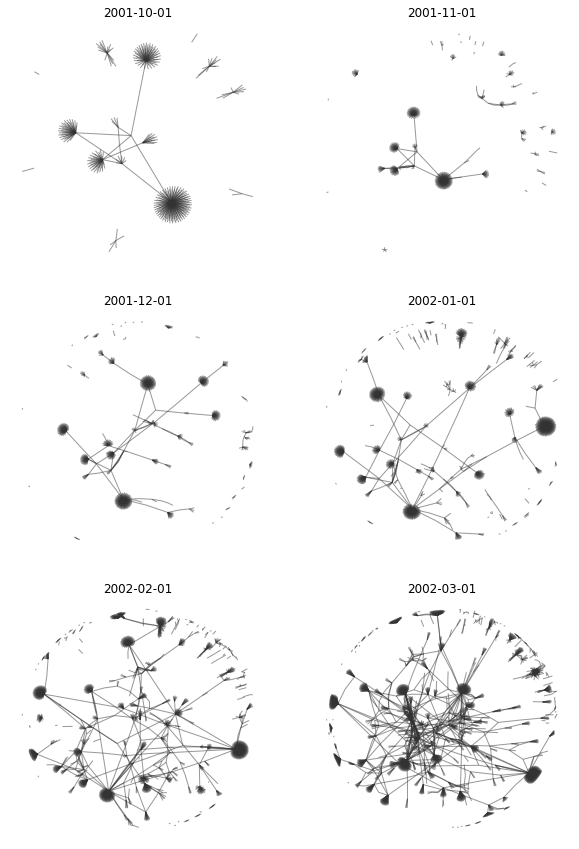

In [108]:
dates = [
    '2001-10-01',
    '2001-11-01',
    '2001-12-01',
    '2002-01-01',
    '2002-02-01',
    '2002-03-01',
]

# Create a figure
plt.figure(figsize=(10, 15))
# Visualize the network for each date
for i, date in enumerate(dates):
    # Get a snapshot of the network
    G = get_snapshot(G_wiki, date)
    # Create a subplot
    plt.subplot(3, 2, i + 1)
    plt.title(date)
    # Calculate the layout
    pos = nx.spring_layout(G, pos=pos, k=0.09)
    # Visualize
    nx.draw_networkx(G, pos=pos, alpha=0.5, edge_color='#333333', node_size=0, with_labels=False)

In [117]:
from tqdm import tqdm
year = 2001
month = 10
clustering = []
for i in tqdm(range(24)):
    date = '{}-{}-01'.format(year, month)
    G = get_snapshot(G_wiki, date)
    clustering.append(nx.average_clustering(G))
    # Update month and year
    month += 1
    if month > 12:
        month -= 12
        year += 1

100%|██████████| 24/24 [10:58<00:00, 55.25s/it]


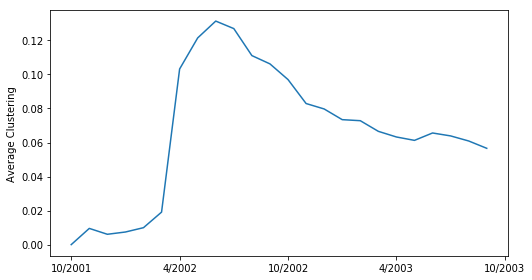

In [128]:
# Create figure
plt.figure(figsize=(7.5, 4))
ax = plt.subplot(1, 1, 1)
for spine in ax.spines.values():
    spine.set_visible(True)
# Plot clustering over time
plt.plot(clustering)
# Add labels and ticks
plt.ylabel('Average Clustering')
plt.xticks(
    [0, 6, 12, 18, 24],
    ['10/2001', '4/2002', '10/2002', '4/2003', '10/2003'])
plt.tight_layout()